In [14]:
import os
import glob
import xarray as xr
import regionmask
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

In [18]:
def pltpolar(x, y, var, ice, ax, mycmap=cm.Spectral_r, mylevels=np.linspace(0, 100., num=11),
             mylabel='', myextend='both', myfontsize=9, hemisphere='nh'):
    
    if hemisphere == 'nh':
        m = Basemap(projection='npstere', boundinglat=70, lon_0=0, resolution='l', ax=ax)
    else:
        m = Basemap(projection='spstere', boundinglat=-55, lon_0=180, resolution='l', ax=ax)

    m.drawcoastlines(color='grey')

    x, y = np.meshgrid(x, y)
    cs = m.contourf(x, y, var, cmap=mycmap, levels=mylevels, latlon=True, extend=myextend)
    m.contour(x, y, ice, levels=[50], latlon=True, linewidths=2, colors='black')

    ax.set_title(mylabel)

    # Plot red lines
    x, y = m(np.linspace(-15, -15, 100), np.linspace(70, 90, 100))
    m.plot(x, y, color='red', linewidth=1)
    x, y = m(np.linspace(55, 55, 100), np.linspace(70, 90, 100))
    m.plot(x, y, color='red', linewidth=1)
    x, y = m(np.linspace(-15, 55, 100), np.linspace(70, 70, 100))
    m.plot(x, y, color='red', linewidth=1)

    return cs

In [19]:
##### Loading Observed Low Cloud Cover (Arctic: 50N–90N) #####

cloud_fraction_dir = '/home/rcostell/Observation_Files/CALIPSO_GOCCP/LowMidHigh/'

# Define fixed season for Arctic (Northern Hemisphere winter: DJF)
season_nh = 'DJF'

# Load all monthly files (2007–2014)
clfr_data = []
for year in range(2007, 2015):
    for month in range(1, 13):
        filename = os.path.join(cloud_fraction_dir, f'MapLowMidHigh330m_{year}{month:02d}_avg_CFMIP1_sat_3.1.2.nc')
        if not os.path.exists(filename):
            print(f"File not found: {filename}")
            continue
        ds = xr.open_dataset(filename)
        clfr_data.append(ds['cllcalipso'])

# Concatenate across all months
clfr_all_months = xr.concat(clfr_data, dim='time')

# Compute seasonal mean for DJF
clfr_avg_season_nh = clfr_all_months.groupby("time.season").mean(dim="time").sel(season=season_nh)

# Select Arctic latitudes and convert to percentage
clfr_avg_nh = clfr_avg_season_nh.sel(latitude=slice(50, 90)) * 100

# Apply land mask (keep ocean only)
nh_lon = clfr_avg_nh.longitude
nh_lat = clfr_avg_nh.latitude
nh_land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(nh_lon, nh_lat)
clfr_avg_nh = clfr_avg_nh.where(nh_land_mask != 0)

print("Processed observed low cloud cover for the Arctic")

# Load regridded Northern Hemisphere sea ice concentration (NSIDC)
path = '/home/rcostell/Observation_Files/NSIDC/Regridded_Sea_Ice_Concentration/Monthly/Northern_Hemisphere/'
file_pattern = '*_nh_*regridded*.nc'
files = sorted(glob.glob(path + file_pattern))

# Combine all monthly files into one dataset
f0 = xr.open_mfdataset(files, combine='nested', concat_dim='tdim')
f0 = f0.rename({'tdim': 'time'})
f0['time'] = xr.decode_cf(f0)['time']

# Compute DJF seasonal mean sea ice concentration
f0 = f0.resample(time='1M').mean()
f0 = f0.groupby("time.season").mean().sel(season="DJF")

# Coordinates from observed cloud fraction dataset
lat_cloud_obs = clfr_avg_nh.latitude
lon_cloud_obs = clfr_avg_nh.longitude

# Coordinates and variable from sea ice dataset
lon_ice_obs = f0.cdr_seaice_conc_gridded.lon.values
lat_ice_obs = f0.cdr_seaice_conc_gridded.lat.values
cllcalipso = clfr_avg_nh
ice_obs = f0.cdr_seaice_conc_gridded

print("Processed observed sea ice cover for the Arctic")

Processed observed low cloud cover for the Arctic


/tmp/ipykernel_805052/3437400819.py:43: UserWarning: rename 'tdim' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  f0 = f0.rename({'tdim': 'time'})
/home/rcostell/.conda/envs/met2025/lib/python3.10/site-packages/xarray/groupers.py:490: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


Processed observed sea ice cover for the Arctic


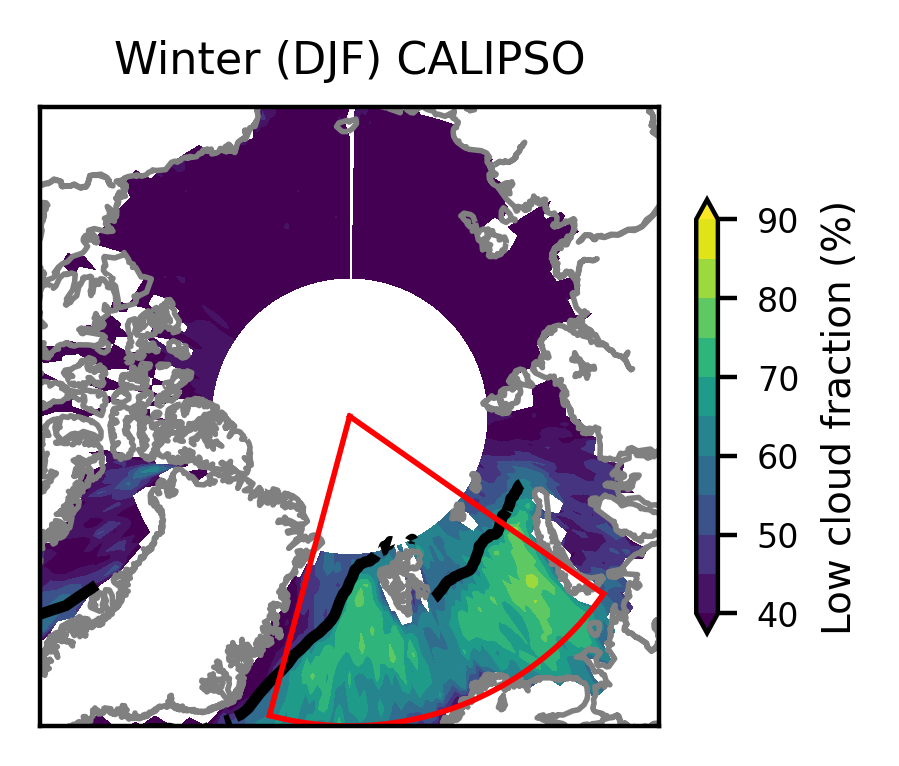

In [21]:
fig, ax = plt.subplots(figsize=(2.5, 1.8), dpi=400)

# Plot cloud fraction and sea ice edge
cs = pltpolar(
    lon_ice_obs, lat_ice_obs, cllcalipso, ice_obs * 100, ax,
    mycmap=cm.viridis, mylabel='Winter (DJF) CALIPSO',
    myfontsize=7, mylevels=np.linspace(40, 90., num=11)
)

# Add smaller vertical colorbar on the right-hand side
cbar = fig.colorbar(
    cs, ax=ax, orientation='vertical',
    pad=0.04, shrink=0.7, extend='both'
)
cbar.set_label("Low cloud fraction (%)", fontsize=7)
cbar.ax.tick_params(labelsize=6)

# Adjust layout and title
ax.title.set_fontsize(8)
plt.tight_layout(pad=0.3)
fig.savefig("Fig_1_Cloud_Map.png", dpi=400, bbox_inches='tight')
plt.show()